In [1]:
from keychestenv import KeyChestEnvironmentRandom, KeyChestGymEnv, KeyChestEnvironment
from keychestenv_gui import jupyter_gui
from keychestenv_gofa import features_for_obs, max_reward, hardcoded_policy_step
from matplotlib import pyplot as plt
from helpers import get_env_performance
import numpy as np
from tqdm import tqdm
from time import time

In [2]:
reward = {'step': -.1, 'food_collected': 3, 'key_collected': 4, 'chest_opened': 5}

env = KeyChestGymEnv(engine_constructor=KeyChestEnvironmentRandom,
                     width=10, height=10, initial_health=15, food_efficiency=15,
                     reward_dict=reward)

/home/sergei/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
print("Steps per second:", get_env_performance(env, 3))

Steps per second: 7118.666666666667


In [6]:
import gym
env1 = gym.make('CartPole-v0')
get_env_performance(env1, 3)

64590.333333333336

In [3]:
features_for_obs(env.reset())

{'player_position_x': 7,
 'player_position_y': 8,
 'lamp_state': 0,
 'at_food': False,
 'at_key': False,
 'at_chest': False,
 'at_button': False,
 'health': 15.0,
 'keys_collected': 0.0}

In [32]:
mr = max_reward(env)
mr

19.5

In [20]:
def reward_on_policy(env, policy):
    done = False
    Rmax = max_reward(env)
    obs = env.reset()
    R = 0
    while not done:
        act = policy(env)
        obs, rew, done, info = env.step(act)
        #plt.imshow(env.render(mode='rgb_array'))
        #plt.show()
        R += rew
    #print(f"Reward {R} out of {Rmax}")
    return R

In [42]:
rews = [reward_on_policy(env, hardcoded_policy_step) for _ in tqdm(range(500))]

100%|██████████| 500/500 [00:07<00:00, 66.08it/s]


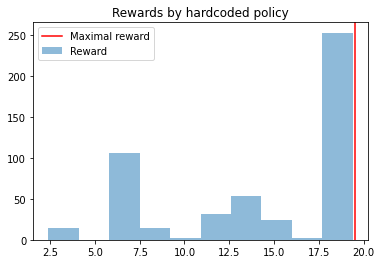

In [43]:
plt.title("Rewards by hardcoded policy")
plt.hist(rews, alpha=0.5, label='Reward')
plt.axvline(mr, color='red', label='Maximal reward')
plt.legend()
plt.show()

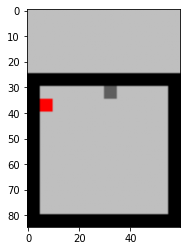

left (0, -1) 3 -0.1 True {'action': 3, 'event': 'already_dead', 'moves': 45} 19.399999999999984
TOTAL REWARD 19.399999999999984


KeyboardInterrupt: Interrupted by user

In [6]:
jupyter_gui(env)